In [1]:
## Imports and Seed
import os
import glob
import random
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split

# Set random seed for reproducibility
torch.manual_seed(22)
np.random.seed(22)
random.seed(22)

In [2]:
path_to_load = r'preprocessing/'
scenario = 'scenario_6'

train_data_tot_np = np.load(r'{}X_train_{}.npy'.format(path_to_load,scenario))
train_labels_tot_np = np.load(r'{}y_train_{}.npy'.format(path_to_load,scenario))
val_data_tot_np = np.load(r'{}X_validation_{}.npy'.format(path_to_load,scenario))
val_labels_tot_np = np.load(r'{}y_validation_{}.npy'.format(path_to_load,scenario))
test_data_tot_np = np.load(r'{}X_test_{}.npy'.format(path_to_load,scenario))
test_labels_tot_np = np.load(r'{}y_test_{}.npy'.format(path_to_load,scenario))

# IMPORTANT: The new labels are sinusoidal representations: 
# [ sin(2*pi*phi/100), cos(2*pi*phi/100) ].
# Hence, we convert the labels to float32 (not long) and expect two outputs.
train_dataset = TensorDataset(torch.tensor(train_data_tot_np, dtype=torch.float32),
                              torch.tensor(train_labels_tot_np, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(val_data_tot_np, dtype=torch.float32),
                              torch.tensor(val_labels_tot_np, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_data_tot_np, dtype=torch.float32),
                              torch.tensor(test_labels_tot_np, dtype=torch.float32))

batch_size = 128 #TODO: Set batch size.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [3]:
# Get a batch from the train_loader
batch_data, batch_labels = next(iter(train_loader))
print("Batch shape:", batch_data.shape)
print("Number of batches:", len(train_loader))
print("Total samples:", len(train_loader.dataset))
print(batch_data.shape[-1])
window_size = batch_data.shape[-1]
num_windows = batch_data.shape[0]
print("Label shape:", batch_labels.shape)
batch_data, batch_labels = next(iter(test_loader))
print("Batch shape:", batch_data.shape)
print("Label shape:", batch_labels.shape)
print("Number of batches:", len(test_loader))
print("Total samples:", len(test_loader.dataset))




Batch shape: torch.Size([128, 12, 100])
Number of batches: 421
Total samples: 53883
100
Label shape: torch.Size([128, 2])
Batch shape: torch.Size([2613, 12, 100])
Label shape: torch.Size([2613, 2])
Number of batches: 1
Total samples: 2613


In [4]:
## Baseline CNN Model for Gait Phase Estimation (Regression)
class BaselineGaitPhaseCNN(nn.Module):
    def __init__(
        self,
        num_channels=12,      # Number of input channels (e.g., 12 for shank+thigh IMU)
        sequence_length=window_size,  # Input time window length
        output_dim=2,         # Regression output dimension now 2 for [sin, cos]
        conv_filters=[32, 64],# Filters for each conv block (2 blocks in this example)
        kernel_size=3,        # Kernel size for all conv layers
        stride=1,             # Stride for all conv layers
        padding=0,            # Padding for all conv layers
        dilation=1,           # Dilation for all conv layers
        pool_size=2,          # Max-pooling factor
        hidden_units=100,     # Units in the first fully connected layer
        dropout_rate=0.5,     # Dropout probability
        activation='relu'     # Activation function: 'relu', 'sigmoid', or 'tanh'
    ):

        super(BaselineGaitPhaseCNN, self).__init__()
        
        self.num_channels = num_channels
        self.activation_choice = activation.lower()
        self.conv_blocks = nn.ModuleList()
        
        # Track current number of channels and current sequence length.
        in_channels = num_channels
        L = sequence_length

        # Function to calculate output length after a 1D convolution (with dilation)
        def conv_output_length(L_in, kernel_size, stride, padding, dilation):
            return (L_in + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

        # Helper function to choose an activation function
        def get_activation_fn(act):
            if act == 'relu':
                return nn.ReLU()
            elif act == 'sigmoid':
                return nn.Sigmoid()
            elif act == 'tanh':
                return nn.Tanh()
            else:
                raise ValueError("Unsupported activation function. Choose 'relu', 'sigmoid', or 'tanh'.")
        
        act_fn = get_activation_fn(self.activation_choice)
        
        # Build each convolutional block
        for i, out_channels in enumerate(conv_filters):
            stride_val = stride[i] if isinstance(stride, list) else stride
            block = nn.Sequential(
                nn.Conv1d(in_channels, out_channels,
                        kernel_size=kernel_size,
                        stride=stride_val,
                        padding=padding,
                        dilation=dilation),
                nn.BatchNorm1d(out_channels),
                act_fn,
                nn.MaxPool1d(pool_size)
            )
            self.conv_blocks.append(block)
            
            L_conv = conv_output_length(L, kernel_size, stride_val, padding, dilation)
            L_pool = L_conv // pool_size
            L = L_pool
            in_channels = out_channels

        
        # Flattened size after all convolutional blocks
        flattened_size = in_channels * L
        
        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, hidden_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_units, output_dim)
        
        # Activation for FC layers using the same activation choice
        self.fc_activation = get_activation_fn(self.activation_choice)
        
    def forward(self, x):

        # print("Input shape:", x.shape)
        
        # If the printed shape shows (batch_size, 12, window_size), then no rearrangement is necessary. 
        # However, if you see (batch_size, window_size, 12), then you would need to transpose x using:
        # x = x.transpose(1, 2)
        
        # Pass through each convolutional block
        for block in self.conv_blocks:
            x = block(x)
        
        # Flatten the features using torch.flatten
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layers
        x = self.fc_activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x) 
        # x = F.normalize(x, p=2, dim=1) # Normalize the output to unit length        
        return x

In [5]:
## Training and Evaluation Functions (Regression) with Early Stopping
def train_model(model, device, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience=5):
    """
    Train the model with early stopping and return the best model along with loss histories.
    """
    best_model_weights = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    train_loss_history = []
    val_loss_history = []
    epochs_since_improvement = 0
    
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * data.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_loss_history.append(epoch_train_loss)
        
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item() * data.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_loss_history.append(epoch_val_loss)
        
        scheduler.step()
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
        
        # Early stopping: if no improvement for 'patience' epochs, break.
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1
            
        if epochs_since_improvement >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break

    model.load_state_dict(best_model_weights)
    return model, train_loss_history, val_loss_history

def test_model(model, device, test_loader, criterion):
    """
    Evaluate the model on the test set and return the average test loss.
    """
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            print("Output shape:", outputs.shape)
            print("Target shape:", targets.shape)
            loss = criterion(outputs, targets)
            running_test_loss += loss.item() * data.size(0)
    test_loss = running_test_loss / len(test_loader.dataset)
    return test_loss

In [6]:
# Hyperparameters for changes
num_scenario='data'
sequence_length = window_size # is dynamic by data definitions
batch_size = batch_size # so called `num_windows`
num_epochs = 50
learning_rate = 1e-3 #!!
dropout_rate = 0.5 #!!
patience = 20  # Early stopping patience
conv_filters=[32, 64] # Filters for each conv block (2 blocks in this example)
kernel_size=3        # Kernel size for all conv layers
stride=1             # Stride for all conv layers
padding=0            # Padding for all conv layers
dilation=1           # Dilation for all conv layers
pool_size=2          # Max-pooling factor !!
hidden_units=100     # Units in the first fully connected layer
activation='relu'     # Activation function: 'relu', 'sigmoid', or 'tanh'

# Hyperparameter tuning for optimizer and loss function:
hyperparams = {
    "optimizer": "adam",       # Options: "adam", "sgd"
    "loss_function": "mse",      # Options: "mse", "mae", "huber"
}


Running on device: cpu
Epoch [1/50] Train Loss: 0.0794 | Val Loss: 0.0732
Epoch [2/50] Train Loss: 0.0568 | Val Loss: 0.0711
Epoch [3/50] Train Loss: 0.0551 | Val Loss: 0.0721
Epoch [4/50] Train Loss: 0.0544 | Val Loss: 0.0754
Epoch [5/50] Train Loss: 0.0531 | Val Loss: 0.0747
Epoch [6/50] Train Loss: 0.0528 | Val Loss: 0.0728
Epoch [7/50] Train Loss: 0.0526 | Val Loss: 0.0773
Epoch [8/50] Train Loss: 0.0516 | Val Loss: 0.0712
Epoch [9/50] Train Loss: 0.0512 | Val Loss: 0.0731
Epoch [10/50] Train Loss: 0.0505 | Val Loss: 0.0742
Epoch [11/50] Train Loss: 0.0482 | Val Loss: 0.0713
Epoch [12/50] Train Loss: 0.0477 | Val Loss: 0.0727
Epoch [13/50] Train Loss: 0.0469 | Val Loss: 0.0702
Epoch [14/50] Train Loss: 0.0468 | Val Loss: 0.0722
Epoch [15/50] Train Loss: 0.0468 | Val Loss: 0.0707
Epoch [16/50] Train Loss: 0.0464 | Val Loss: 0.0712
Epoch [17/50] Train Loss: 0.0464 | Val Loss: 0.0707
Epoch [18/50] Train Loss: 0.0465 | Val Loss: 0.0705
Epoch [19/50] Train Loss: 0.0462 | Val Loss: 0.069

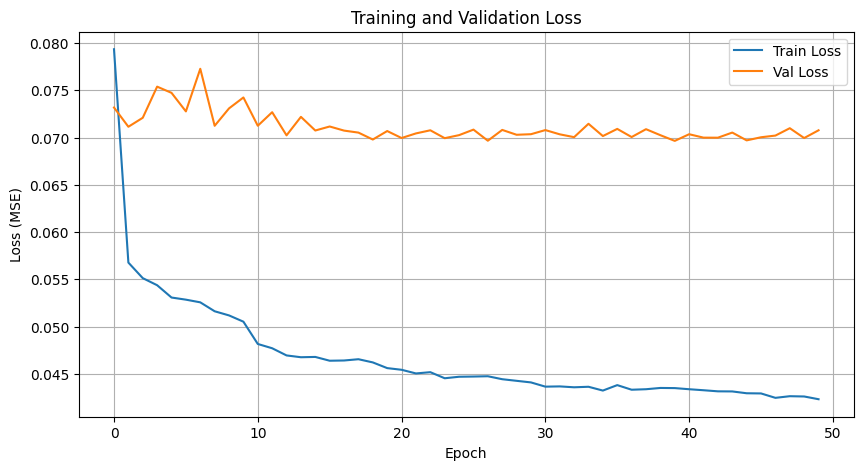

Output shape: torch.Size([2613, 2])
Target shape: torch.Size([2613, 2])
Test Loss (MSE): 0.0331


In [7]:
# model = BaselineGaitPhaseCNN() # This is the baseline model
model = BaselineGaitPhaseCNN(
    num_channels=12, 
    sequence_length=sequence_length, 
    output_dim=2,
    conv_filters=conv_filters,
    kernel_size=kernel_size, 
    stride=stride, 
    padding=padding,
    dilation=dilation, 
    pool_size=pool_size,   
    hidden_units=hidden_units,  
    dropout_rate=dropout_rate, 
    activation=activation 
)
# Choose the loss function
loss_fn = hyperparams["loss_function"].lower()
if loss_fn == "mse":
    criterion = nn.MSELoss()
elif loss_fn == "mae":
    criterion = nn.L1Loss()
elif loss_fn == "huber":
    criterion = nn.SmoothL1Loss()
else:
    raise ValueError("Unsupported loss function. Choose 'mse', 'mae', or 'huber'.")

# Choose the optimizer
optim_choice = hyperparams["optimizer"].lower()
if optim_choice == "adam":
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif optim_choice == "sgd":
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
else:
    raise ValueError("Unsupported optimizer. Choose 'adam' or 'sgd'.")

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on device:", device)

# Train the model with early stopping
model, train_loss_hist, val_loss_hist = train_model(
    model, device, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience=patience)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate on test set
test_loss = test_model(model, device, test_loader, criterion)
print(f"Test Loss (MSE): {test_loss:.4f}")

# Performance metrics
evaluate the data according to phase estimation difference 

In [8]:
def calculate_delta_phi_vector(y1,y2,y1_hat,y2_hat):
    # Ensure inputs are NumPy arrays (in case they are lists)
    y1, y2, y1_hat, y2_hat = map(np.asarray, [y1, y2, y1_hat, y2_hat])
    # Compute angles using element-wise operations
    delta_phi = np.arctan2(y2_hat * y1 - y1_hat * y2, y1_hat * y1 + y2_hat * y2)
    delta_phi = delta_phi / (2 * np.pi)
    return delta_phi  # Returns a NumPy array

def calculate_sRMSE(y_pred,y_actual):
    # this code uses the assumption that y_pred and y_actual are in the dimensions: [num_examples,2]
    y1 = y_actual[:,0]
    y2 = y_actual[:,1]
    y1_hat = y_pred[:,0]
    y2_hat = y_pred[:,1]
    # Ensure inputs are NumPy arrays (in case they are lists)
    y1, y2, y1_hat, y2_hat = map(np.asarray, [y1, y2, y1_hat, y2_hat])
    # compute delta_phi:
    delta_phi_values = calculate_delta_phi_vector(y1, y2, y1_hat, y2_hat)
    # calculate the sRMSE :
    sRMSE = np.sqrt(np.power(delta_phi_values, 2).mean())
    return sRMSE

def get_y_pred_and_actual_on_validation(model, device, val_loader):
    model.eval()  # Set model to evaluation mode
    all_preds, all_targets = [], []

    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)

            # Move data to CPU and convert to NumPy
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Concatenate all batches
    y_pred = np.vstack(all_preds)
    y_actual = np.vstack(all_targets)
    return y_pred, y_actual

def draw_angles(y_pred,y_actual):
    angles_pred = np.arctan2(y_pred[:, 1], y_pred[:, 0]) / (2 * np.pi)
    angles_actual = np.arctan2(y_actual[:, 1], y_actual[:, 0]) / (2 * np.pi)
    # make sure that the phases are between 0 and 1
    angles_pred = (angles_pred + 1) % 1
    angles_actual = (angles_actual + 1) % 1
    # Scatter plot of actual vs. predicted angles
    plt.figure(figsize=(6, 6))
    plt.scatter(angles_actual, angles_pred, alpha=0.5, edgecolors='k')
    # Reference line (perfect predictions)
    plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
    # Labels and title
    plt.xlabel("Actual Angles (cycles)")
    plt.ylabel("Predicted Angles (cycles)")
    plt.title("Predicted vs. Actual Angles")
    plt.legend()
    plt.grid(True)
    # Show the plot
    plt.show()

def compute_loss(model, data_loader, loss_type, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0

    # Choose the correct loss function
    if loss_type == "mse":
        criterion = nn.MSELoss()
    elif loss_type == "mae":
        criterion = nn.L1Loss()
    elif loss_type == "huber":
        criterion = nn.SmoothL1Loss()
    else:
        raise ValueError("Unsupported loss type. Choose 'mse', 'mae', or 'huber'.")

    with torch.no_grad():
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * data.size(0)

    return total_loss / len(data_loader.dataset)


In [9]:
# save the plots:
torch.save({
    'model_state_dict': model.state_dict(),
    'model_params': {
    # architecture parameters
    'num_channels': model.num_channels,
    'sequence_length': window_size,
    'conv_filters': conv_filters,
    'kernel_size': kernel_size,
    'stride': stride,
    'padding': padding,
    'dilation': dilation,
    'pool_size': pool_size,
    'hidden_units': hidden_units,
    'dropout_rate': dropout_rate,
    'activation': activation,
    'output_dim': 2,
    # training Hyperparameters
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'patience': patience,
    'learning_rate': learning_rate,
    'optimizer': hyperparams["optimizer"],
    'loss_function': hyperparams["loss_function"]
    }

}, 'saved_model_{}_{}.pth'.format(num_scenario, scenario))

 # Real Time Phase Estimation Plots

Recalculated Training Loss: 0.0124
Recalculated Validation Loss: 0.0697
Validation sRMSE: 6.5259 %


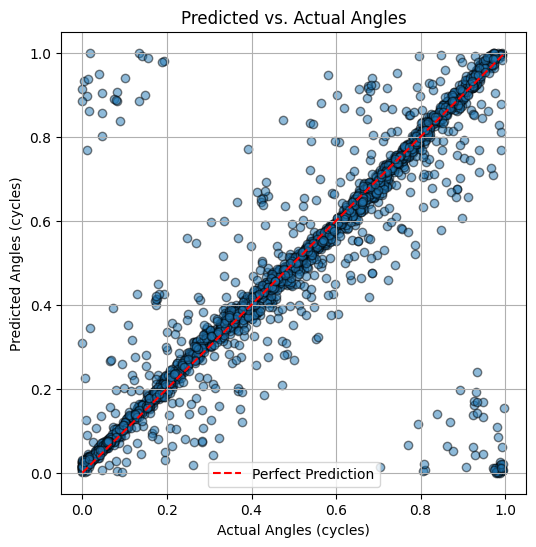

In [10]:
# get predicted and actual labels for validation data:
y_pred, y_actual = get_y_pred_and_actual_on_validation(model, device, val_loader)
# compute the loss
final_train_loss = compute_loss(model, train_loader, "mse", device)
final_val_loss = compute_loss(model, val_loader, "mse", device)
# Compute sRMSE on validation data:
sRMSE = calculate_sRMSE(y_pred,y_actual)
# Print results
print(f"Recalculated Training Loss: {final_train_loss:.4f}")
print(f"Recalculated Validation Loss: {final_val_loss:.4f}")
print(f"Validation sRMSE: {100*sRMSE:.4f} %")
draw_angles(y_pred,y_actual)

scenario_6 - filter: True, type: causal, normalize: True, window size: 100, overlap: 25
[0.5144802  0.34066311 0.68807151 1.47894345 2.93140232 0.81457493
 0.46524249 0.50342309 0.45809445 1.49931838 1.02440356 1.68379647]
[-1.13963791  0.04361339 -0.31352053  0.01390039  0.00300192  0.12049409
 -1.03265749 -0.06974683 -0.00689938 -0.01253058 -0.06990009  0.02296905]
Recalculated Validation Loss: 0.0697
Validation sRMSE: 1.8004 %


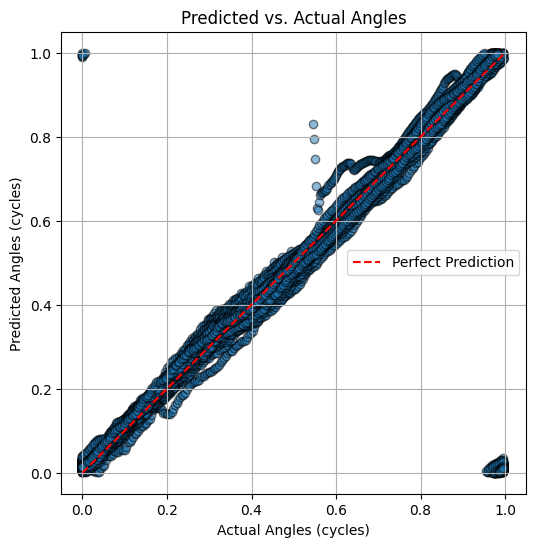

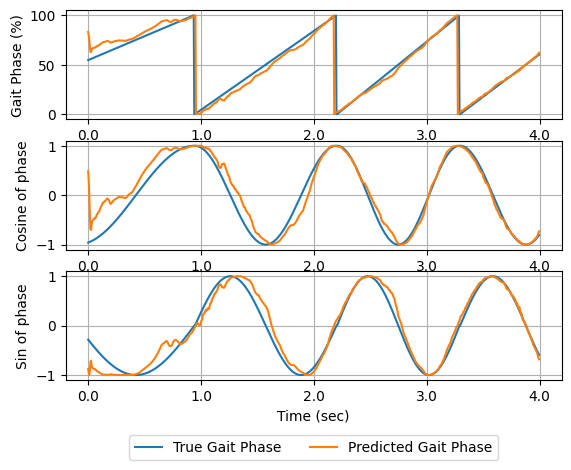

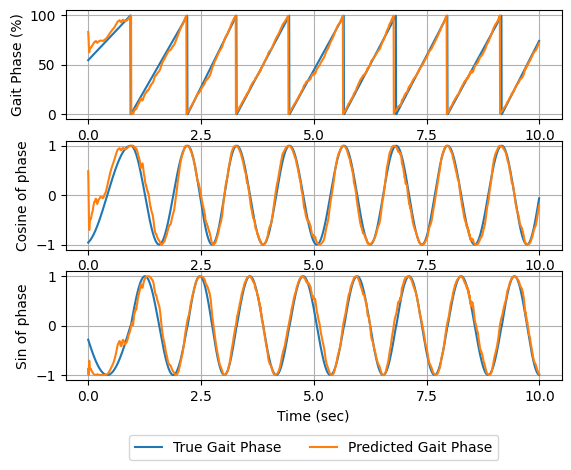

In [11]:
from scipy import signal
import pandas as pd
from scipy.signal import butter, lfilter, filtfilt
from preprocessing.preprocess import sliding_window_with_label, apply_filter
import json

# Load the scenario json file
with open('preprocessing/preprocess_scenarios.json', 'r') as file:
    preprocess_scenarios = json.load(file)
    is_filter = preprocess_scenarios[scenario]['is_filter']
    filter_type = preprocess_scenarios[scenario]['filter_type']
    cutoff = 25                 # cutoff frequency for the filter (Hz)
    is_normalize = preprocess_scenarios[scenario]['is_normalize']
    window_size = preprocess_scenarios[scenario]['window_size']
    overlap = preprocess_scenarios[scenario]['overlap']
print("{} - filter: {}, type: {}, normalize: {}, window size: {}, overlap: {}".format(scenario, is_filter, filter_type, is_normalize, window_size, overlap))


def draw_real_time_plot(y_pred, y_actual, chosen_window=[0, 4000]):
    angles_pred = np.arctan2(y_pred[:, 1], y_pred[:, 0]) / (2 * np.pi)
    angles_actual = np.arctan2(y_actual[:, 1], y_actual[:, 0]) / (2 * np.pi)
    # make sure that the phases are between 0 and 1
    angles_pred = (angles_pred + 1) % 1
    angles_actual = (angles_actual + 1) % 1
    xticks_in_plot = np.linspace(chosen_window[0], chosen_window[1], 5)
    xtick_labels = [f"{x/200:.1f}" for x in xticks_in_plot]
    plt.figure()
    plt.subplot(3,1,1), plt.grid()
    plt.plot(100*angles_actual[chosen_window[0]:chosen_window[1]])
    plt.plot(100*angles_pred[chosen_window[0]:chosen_window[1]])
    plt.xticks(xticks_in_plot, xtick_labels)
    plt.ylabel("Gait Phase (%)")
    plt.subplot(3,1,2), plt.grid()
    plt.plot(y_actual[chosen_window[0]:chosen_window[1],0])
    plt.plot(y_pred[chosen_window[0]:chosen_window[1],0])
    plt.xticks(xticks_in_plot, xtick_labels)
    plt.ylabel("Cosine of phase")
    plt.subplot(3,1,3), plt.grid()
    plt.plot(y_actual[chosen_window[0]:chosen_window[1],1])
    plt.plot(y_pred[chosen_window[0]:chosen_window[1],1])
    plt.ylabel("Sin of phase")
    plt.xticks(xticks_in_plot, xtick_labels)
    plt.legend(['True Gait Phase', 'Predicted Gait Phase'], loc='lower center', bbox_to_anchor=(0.5, -0.8), ncol=2)
    plt.xlabel("Time (sec)")
    plt.show()
    pass

def load_validation_for_real_time() -> torch.utils.data.DataLoader:
    # Load the test mean and std for normalization (if needed)
    mean_std = np.load('preprocessing/mean_std_train.npy')
    mean_train = mean_std[0]
    std_train = mean_std[1]

    # Load the validation file for example
    imu_df = pd.read_csv(os.path.join('dataset', 'AB10', 'treadmill', 'imu', 'treadmill_06_01_data.csv')) # !!!!!!!!!!! Arbitrary choice !!!!!!!!
    gc_df = pd.read_csv(os.path.join('dataset', 'AB10', 'treadmill', 'gcRight', 'treadmill_06_01_data.csv'))

    # Preallocate the validation data
    X_validation_data = np.empty((0, 12, window_size))
    y_validation_data = np.empty((0, 2))

    # remove unnecessary columns
    gc_df = gc_df.drop(columns=["ToeOff"])
    imu_df = imu_df.drop(columns=['foot_Accel_X', 'foot_Accel_Y', 'foot_Accel_Z', 'foot_Gyro_X', 'foot_Gyro_Y', 'foot_Gyro_Z', 'trunk_Accel_X', 'trunk_Accel_Y', 'trunk_Accel_Z', 'trunk_Gyro_X', 'trunk_Gyro_Y', 'trunk_Gyro_Z'])

    # remove the first and last samples that have no proper label defined (until the first Heel Strike occurance + after the last Toe Off occurance)
    gc_df = gc_df.loc[gc_df.index[gc_df["HeelStrike"].gt(0)].min() : gc_df.index[gc_df["HeelStrike"] == 100].max()]
    imu_df = imu_df[imu_df["Header"].isin(gc_df["Header"])] # remove the rows that are not in the gc data

    # Apply the cosine and sine functions to the HeelStrike column
    gc_df['cos_gait_phase'] = np.cos(gc_df['HeelStrike'] * 2 * np.pi / 100)
    gc_df['sin_gait_phase'] = np.sin(gc_df['HeelStrike'] * 2 * np.pi / 100)

    # remove header and other columns
    gc_df.drop(columns=["Header","HeelStrike"], inplace=True)
    imu_df.drop(columns=['Header'], inplace=True)

    gc_df.reset_index(drop=True, inplace=True)
    imu_df.reset_index(drop=True, inplace=True)

    # Apply a filter to the IMU data (choose between a causal and non-causal filter i.e. with phase or zero phase lag filters)
    # filter_type = "causal" # or "non-causal" - defined in the scenario parameters settings section
    filtered_df = pd.DataFrame(apply_filter(imu_df.values, filter_type='causal', cutoff=25, order=4), columns=imu_df.columns) if is_filter else imu_df

    # Normalize the input data (is_normalize = True or False)
    filtered_df = (filtered_df - mean_train) / std_train if is_normalize else filtered_df
    print(std_train)
    print(mean_train)
    
    # Split the data into windows (by window size and overlap)
    X_windows, y_labels = sliding_window_with_label(filtered_df, gc_df, window_size=window_size, overlap = window_size-1) # this ensures that the windows will run one by one as they do in real time...

    # Concatenate the data to the multidimensional array according to the validation data matrix
    X_validation_data = np.concatenate((X_validation_data, X_windows), axis=0)
    y_validation_data = np.concatenate((y_validation_data, y_labels), axis=0)

    val_dataset = TensorDataset(torch.tensor(X_validation_data, dtype=torch.float32),
                                torch.tensor(y_validation_data, dtype=torch.float32))
    batch_size = 128 
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
    return val_loader


real_time_val_loader = load_validation_for_real_time()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Set a device

# get predicted and actual labels for validation data:
y_pred, y_actual = get_y_pred_and_actual_on_validation(model, device, real_time_val_loader)

# normalize y_pred to be unit vectors
y_pred = y_pred / np.linalg.norm(y_pred, axis=1)[:, None]

final_val_loss = compute_loss(model, val_loader, "mse", device)
sRMSE = calculate_sRMSE(y_pred,y_actual)
# Print results
print(f"Recalculated Validation Loss: {final_val_loss:.4f}")
print(f"Validation sRMSE: {100*sRMSE:.4f} %")
draw_angles(y_pred,y_actual)

# Plot the outputs and targets on the same plot as true gait phase and prediction
draw_real_time_plot(y_pred=y_pred, y_actual=y_actual, chosen_window=[0,800])
draw_real_time_plot(y_pred=y_pred, y_actual=y_actual, chosen_window=[0,2000])



In [12]:
# check if torch gpu available
print(torch.cuda.is_available())

False
